In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

In [4]:
df1 = pd.read_csv("datasets/ApoA.csv", usecols=["eid", "30630-0.0"])
df1.rename(columns={"30630-0.0": "apoA"}, inplace=True)

df2 = pd.read_csv("datasets/packyears.csv", usecols=["eid", "pack_years"])
df2.rename(columns={"pack_years": "Pack years"}, inplace=True)


df3 = pd.read_csv("datasets/other.csv", usecols=["eid", "Smoking", "BMI", "Age", "Gender", "SBP", "DBP"])

#alcohol_df = pd.read_csv("datasets/cox.csv", usecols=["eid", "alcohol_intake"])

df4 = pd.read_csv("datasets/traditional_cvd_risk_factors.csv", usecols=[
    "eid", "30760-0.0" , "30690-0.0" , "30870-0.0"
])
df4.rename(columns={
    "30760-0.0": "HDL cholesterol",
    "30690-0.0": "Total cholesterol",
    "30870-0.0": "Triglycerides"
}, inplace=True)



In [5]:
df5 = pd.read_csv("datasets/raw_data.csv")
# Define statin codes
statin_codes = {
    1140861958,  # simvastatin
    1140888594,  # fluvastatin
    1140888648,  # pravastatin
    1141146234,  # atorvastatin
    1141192410   # rosuvastatin
}
df5.rename(columns={
    "884-0.0": "Walking activity",
    "904-0.0": "Moderate activity",
    "21000-0.0": "Ethnicity",
    "30710-0.0": "CRP",
    "30780-0.0": "LDL cholesterol",
}, inplace=True)
df5.drop(columns=["Ethnicity"], inplace=True)

# Identify all medication columns
med_cols = [col for col in df5.columns if col.startswith("20003-")]

# Set statin use = 1 if any statin code appears in that row
df5["statin use"] = df5[med_cols].apply(
    lambda row: int(any(code in statin_codes for code in row.values)), axis=1
)

# Drop the original medication columns
df5.drop(columns=med_cols, inplace=True)
print(df5["statin use"].sum())

# Preview
df5.head()

75689


,eid,Walking activity,Moderate activity,CRP,LDL cholesterol,statin use
0,1000013,3.0,1.0,3.97,3.020,0
1,1000024,5.0,0.0,3.60,4.686,0
2,1000036,5.0,6.0,0.79,2.889,0
3,1000048,7.0,1.0,0.43,3.218,0
4,1000055,4.0,0.0,3.73,3.224,0


In [6]:
df = df1.merge(df2, on="eid", how="left")
df = df.merge(df3, on="eid", how="left")
df = df.merge(df4, on="eid", how="left")
df = df.merge(df5, on="eid", how="left")
df.head()


,eid,apoA,Pack years,Gender,Smoking,BMI,Age,SBP,DBP,Total cholesterol,HDL cholesterol,Triglycerides,Walking activity,Moderate activity,CRP,LDL cholesterol,statin use
0,1000013,1.175,34.875,1,2.0,24.9680,62.0,157.0,86.0,4.898,0.981,3.141,3.0,1.0,3.97,3.020,0
1,1000024,1.453,0.000,1,0.0,27.8769,61.0,156.0,87.0,6.315,1.484,1.703,5.0,0.0,3.60,4.686,0
2,1000036,1.316,0.000,1,0.0,28.5211,47.0,143.5,87.0,4.550,1.108,0.725,5.0,6.0,0.79,2.889,0
3,1000048,2.360,0.000,0,0.0,24.7781,69.0,160.5,90.5,5.635,1.836,2.149,7.0,1.0,0.43,3.218,0
4,1000055,NaN,10.875,0,1.0,44.2469,64.0,148.5,99.5,4.783,NaN,1.994,4.0,0.0,3.73,3.224,0


In [7]:
df.to_csv("merged_data_with_all_statins.csv", index=False)

## new dataset with all statins


In [8]:
df = pd.read_csv("merged_data_with_all_statins.csv")
# Drop "prefer not to answer" in Smoking
#df = df[df["Smoking"] != -3]


# Set pack_years = 0 for never smokers (Smoking == 0)
df.loc[(df["Smoking"] == 0) & (df["Pack years"].isna()), "Pack years"] = 0

# Drop rows with missing apoA (must have label)
#df = df.dropna(subset=["apoA"])

# Drop rows where pack_years is still NaN (e.g., smokers with no data)
#df = df.dropna(subset=["Pack years"])

# Drop any remaining rows with NaNs in features
#df = df.dropna()

#Drop Total cholesterol for multicol
#df.drop(columns=["Total cholesterol"], inplace=True)
nan_counts = df.isna().sum()

# Print the result
print("NaN count per column:")
print(nan_counts)
df.describe()


NaN count per column:
eid                      0
apoA                 74970
Pack years           78014
Gender                   0
Smoking                893
BMI                   3107
Age                      3
SBP                  30117
DBP                  30112
Total cholesterol    32904
HDL cholesterol      72610
Triglycerides        33279
Walking activity       880
Moderate activity      880
CRP                  33925
LDL cholesterol      33787
statin use               0
dtype: int64


,eid,apoA,Pack years,Gender,Smoking,BMI,Age,SBP,DBP,Total cholesterol,HDL cholesterol,Triglycerides,Walking activity,Moderate activity,CRP,LDL cholesterol,statin use
count,5.023700e+05,427400.000000,424356.000000,502370.000000,501477.000000,499263.000000,502367.000000,472253.00000,472258.000000,469466.000000,429760.000000,469091.000000,501490.000000,501490.000000,468445.000000,468583.000000,502370.000000
mean,3.512033e+06,1.537654,8.314634,0.455977,0.543915,27.432817,56.529866,137.82352,82.216401,5.692446,1.448002,1.747623,3.373491,1.671176,2.598751,3.556420,0.150664
std,1.450342e+06,0.270663,15.842955,0.498059,0.713102,4.802894,8.094982,18.67899,10.155898,1.144949,0.382307,1.027677,2.515262,2.039895,4.360855,0.869977,0.357721
min,1.000013e+06,0.419000,0.000000,0.000000,-3.000000,12.121200,37.000000,65.00000,32.000000,0.601000,0.219000,0.231000,-3.000000,-3.000000,0.080000,0.266000,0.000000
25%,2.256018e+06,1.346000,0.000000,0.000000,0.000000,24.138900,50.000000,124.50000,75.000000,4.906000,1.170000,1.046000,1.000000,0.000000,0.660000,2.944000,0.000000
50%,3.512018e+06,1.510000,0.000000,0.000000,0.000000,26.743300,58.000000,136.00000,82.000000,5.650000,1.398000,1.483000,3.000000,1.000000,1.330000,3.516000,0.000000
75%,4.768063e+06,1.697000,11.500000,1.000000,1.000000,29.908400,63.000000,149.50000,89.000000,6.424000,1.674000,2.148000,5.000000,3.000000,2.760000,4.117000,0.000000
max,6.024096e+06,2.500000,336.000000,1.000000,2.000000,74.683700,73.000000,268.00000,147.500000,15.460000,4.401000,11.278000,7.000000,7.000000,79.960000,9.797000,1.000000


In [9]:
# === Save clean dataset ===
df.to_csv("apoa_dataset_all_statins.csv", index=False)
df.describe()

,eid,apoA,Pack years,Gender,Smoking,BMI,Age,SBP,DBP,Total cholesterol,HDL cholesterol,Triglycerides,Walking activity,Moderate activity,CRP,LDL cholesterol,statin use
count,5.023700e+05,427400.000000,424356.000000,502370.000000,501477.000000,499263.000000,502367.000000,472253.00000,472258.000000,469466.000000,429760.000000,469091.000000,501490.000000,501490.000000,468445.000000,468583.000000,502370.000000
mean,3.512033e+06,1.537654,8.314634,0.455977,0.543915,27.432817,56.529866,137.82352,82.216401,5.692446,1.448002,1.747623,3.373491,1.671176,2.598751,3.556420,0.150664
std,1.450342e+06,0.270663,15.842955,0.498059,0.713102,4.802894,8.094982,18.67899,10.155898,1.144949,0.382307,1.027677,2.515262,2.039895,4.360855,0.869977,0.357721
min,1.000013e+06,0.419000,0.000000,0.000000,-3.000000,12.121200,37.000000,65.00000,32.000000,0.601000,0.219000,0.231000,-3.000000,-3.000000,0.080000,0.266000,0.000000
25%,2.256018e+06,1.346000,0.000000,0.000000,0.000000,24.138900,50.000000,124.50000,75.000000,4.906000,1.170000,1.046000,1.000000,0.000000,0.660000,2.944000,0.000000
50%,3.512018e+06,1.510000,0.000000,0.000000,0.000000,26.743300,58.000000,136.00000,82.000000,5.650000,1.398000,1.483000,3.000000,1.000000,1.330000,3.516000,0.000000
75%,4.768063e+06,1.697000,11.500000,1.000000,1.000000,29.908400,63.000000,149.50000,89.000000,6.424000,1.674000,2.148000,5.000000,3.000000,2.760000,4.117000,0.000000
max,6.024096e+06,2.500000,336.000000,1.000000,2.000000,74.683700,73.000000,268.00000,147.500000,15.460000,4.401000,11.278000,7.000000,7.000000,79.960000,9.797000,1.000000


# Model


Our initial analysis suggested multiple weak associations between ApoA and smoking. However, statin use emerged as a strong and gender-dependent predictor of ApoA, with women experiencing significantly greater ApoA increases than men. We therefore focused our analysis on understanding the mechanisms and modifiers of this statin effect.

# Comparison Plot by Statin Use and Gender

NameError: name 'g' is not defined

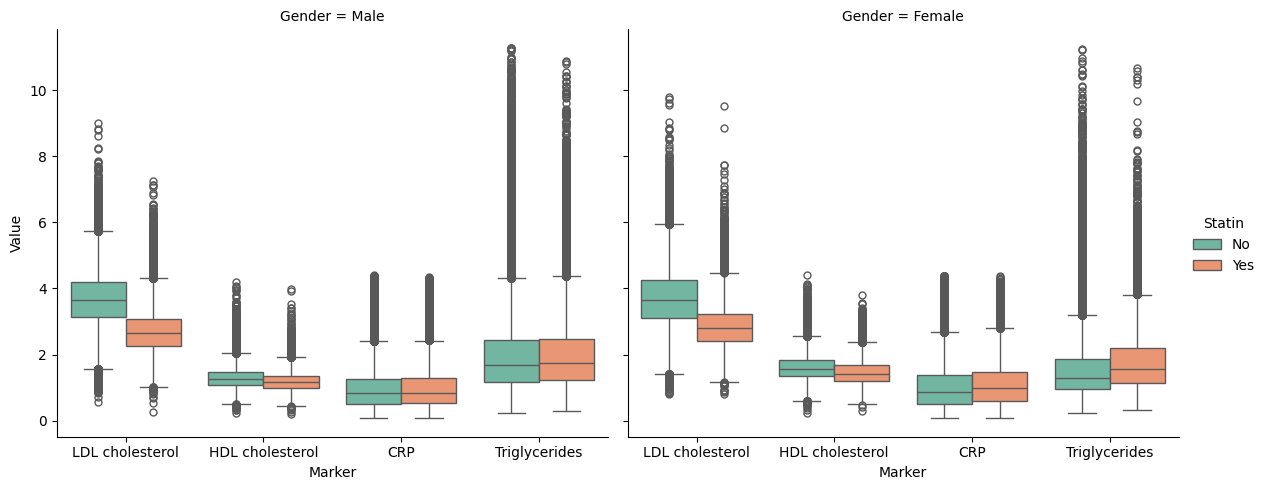

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df_all = pd.read_csv("apoa_dataset_all_statins.csv")
# Select relevant variables
markers = ["LDL cholesterol", "HDL cholesterol", "CRP", "Triglycerides"]
df_plot = df_all[["Gender", "statin use"] + markers].dropna().copy()

# Add readable labels
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"})
df_plot["Statin"] = df_plot["statin use"].map({0: "No", 1: "Yes"})
df_plot["CRP"] = np.log1p(df_plot["CRP"])  # log(1 + CRP) to handle zeros safely

# Reshape for plotting
df_melted = df_plot.melt(
    id_vars=["Gender", "Statin"],
    value_vars=markers,
    var_name="Marker",
    value_name="Value"
)

#plot
sns.catplot(
    data=df_melted, kind="box",
    x="Marker", y="Value", hue="Statin",
    col="Gender", palette="Set2", height=5, aspect=1.2
)
g.set_titles("{col_name}")
g.set_axis_labels("", "Mean Value")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Comparison of Lipid and Inflammation Markers\nby Statin Use and Gender", fontsize=16)

plt.show()


## Comparing Statin Users vs Non-Users: T-Tests and Effect Sizes

In this analysis, we use independent two-sample t-tests to compare the mean levels of key biomarkers 
between statin users and non-users, separately for men and women.

We test:

- **LDL cholesterol** (primary target of statins)
- **HDL cholesterol** (secondary lipid effect)
- **Triglycerides**
- **CRP (log-transformed)** — a marker of inflammation

For each comparison, we also calculate **Cohen’s d** to estimate the effect size, which tells us 
**how big** the difference is, not just whether it is statistically significant.


In [5]:
def compute_t_and_effect(group1, group2):
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    # Cohen's d
    pooled_sd = np.sqrt(((group1.std() ** 2) + (group2.std() ** 2)) / 2)
    cohen_d = (group1.mean() - group2.mean()) / pooled_sd
    return t_stat, p_val, cohen_d

# Markers to test
markers = {
    "LDL cholesterol": "LDL",
    "HDL cholesterol": "HDL",
    "Triglycerides": "TG",
    "CRP": "log(CRP)"
}

# Prepare dataframe
df_test = df_all[["Gender", "statin use", "LDL cholesterol", "HDL cholesterol", "Triglycerides", "CRP"]].dropna().copy()
df_test["CRP"] = np.log1p(df_test["CRP"])  # log-transform CRP safely

results = []

for marker, label in markers.items():
    for gender_val, gender_label in zip([0, 1], ["Female", "Male"]):
        statin_yes = df_test[(df_test["Gender"] == gender_val) & (df_test["statin use"] == 1)][marker]
        statin_no = df_test[(df_test["Gender"] == gender_val) & (df_test["statin use"] == 0)][marker]
        
        t_stat, p_val, d = compute_t_and_effect(statin_yes, statin_no)
        results.append({
            "Marker": label,
            "Gender": gender_label,
            "t-stat": round(t_stat, 3),
            "p-value": round(p_val, 6),
            "Cohen's d": round(d, 3)
        })

df_results = pd.DataFrame(results)
df_results

,Marker,Gender,t-stat,p-value,Cohen's d
0,LDL,Female,-177.477,0.0,-1.093
1,LDL,Male,-253.317,0.0,-1.340
2,HDL,Female,-56.618,0.0,-0.378
3,HDL,Male,-53.415,0.0,-0.296
4,TG,Female,43.967,0.0,0.310
5,TG,Male,6.924,0.0,0.039
6,log(CRP),Female,23.193,0.0,0.156
7,log(CRP),Male,7.415,0.0,0.042


In both sexes, statin use significantly reduced LDL cholesterol with a large effect size (Cohen’s d > 1.1). HDL decreased modestly, more so in women (d = –0.97). Surprisingly, statin use was associated with increased triglycerides and log-transformed CRP levels — with stronger effects in females. These findings suggest sex-specific responses to statins, particularly in lipid and inflammatory profiles, warranting further stratified investigation.

Text(0.5, 1.03, 'Mean Biomarker Levels by Gender & Statin Use')

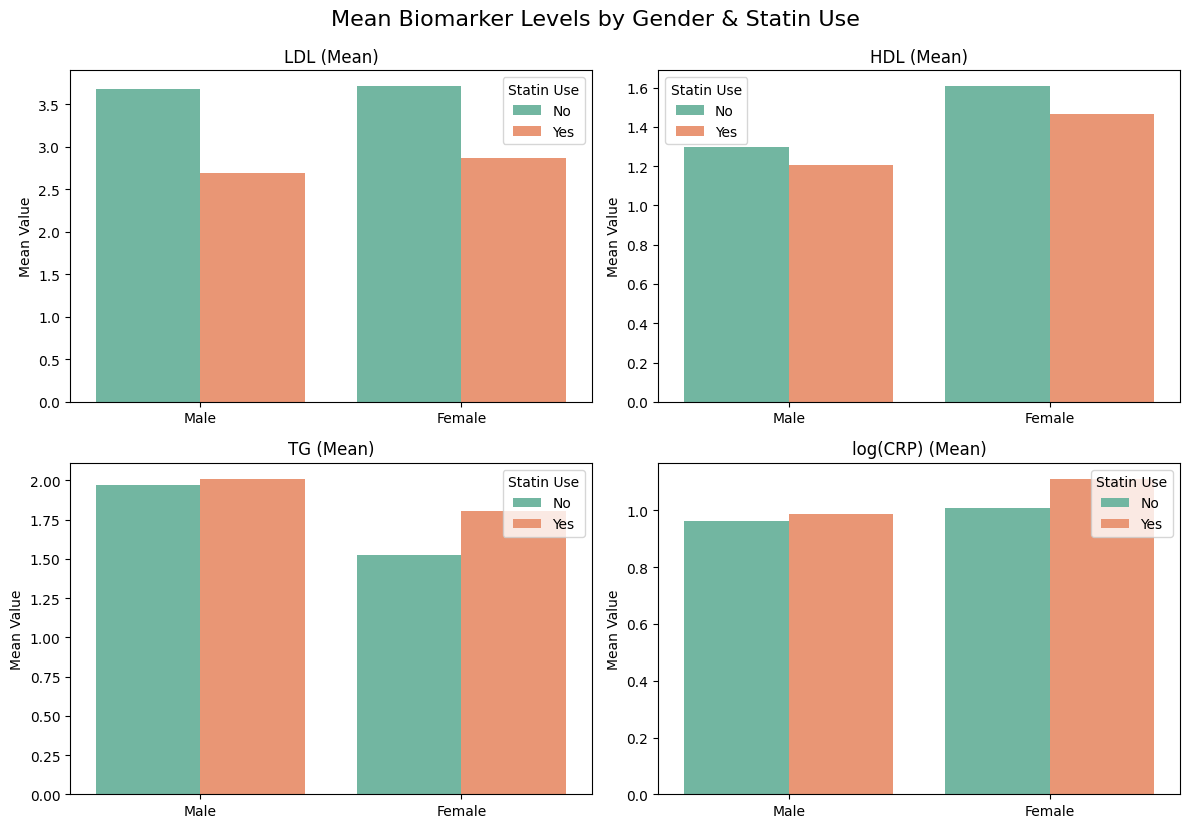

In [7]:
# Create a long-format DataFrame with means per group
df_means = df_all.copy()
df_means["Gender"] = df_means["Gender"].map({0: "Female", 1: "Male"})
df_means["Statin"] = df_means["statin use"].map({0: "No", 1: "Yes"})

# Markers to plot
markers = {
    "LDL cholesterol": "LDL",
    "HDL cholesterol": "HDL",
    "Triglycerides": "TG",
    "CRP": "log(CRP)"
}

# Apply log1p to CRP only (already done above, but in case it's not)
df_means["CRP"] = np.log1p(df_means["CRP"])

# Setup plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot each marker separately
for i, (col, label) in enumerate(markers.items()):
    ax = axes[i]
    sns.barplot(
        data=df_means,
        x="Gender",
        y=col,
        hue="Statin",
        estimator=np.mean,
        errorbar=None,
        ax=ax,
        palette="Set2"
    )
    ax.set_title(f"{label} (Mean)")
    ax.set_ylabel("Mean Value")
    ax.set_xlabel("")
    ax.legend(title="Statin Use")

plt.tight_layout()
plt.suptitle("Mean Biomarker Levels by Gender & Statin Use", fontsize=16, y=1.03)

## LDL levels t-tests by Gender, age and statin use


In [18]:
df = pd.read_csv("apoa_dataset_all_statins.csv")

# Clean and define age groups
df = df.dropna(subset=["LDL cholesterol", "Age", "Gender", "statin use"])
df["Age group"] = df["Age"].apply(
    lambda x: "50 and under" if x <= 50 else "60 and above" if x >= 60 else np.nan
)

# Filter only 50↓ and 60↑
df = df[df["Age group"].notna()]
df["Gender"] = df["Gender"].map({0: "Female", 1: "Male"})
df["Statin"] = df["statin use"].map({0: "No", 1: "Yes"})

Text(0.5, 0.98, 'LDL Levels by Gender, Age Group, and Statin Use')

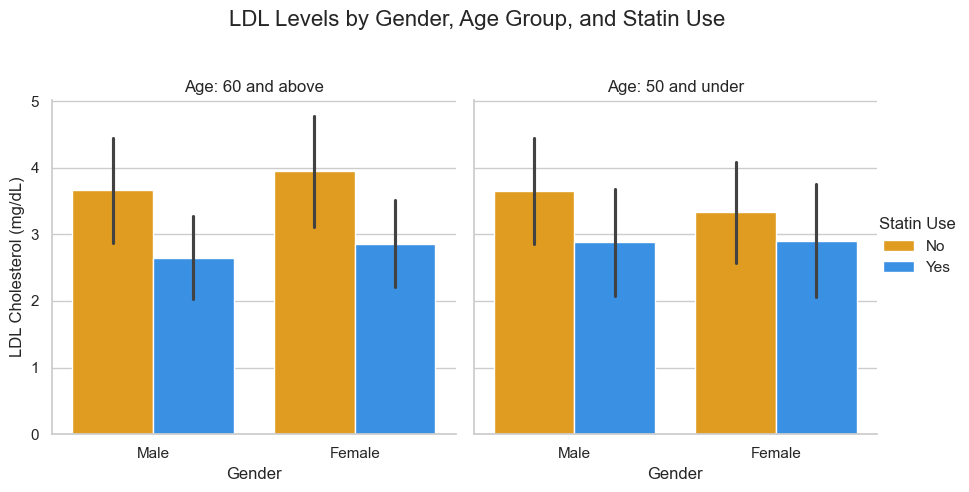

In [20]:
sns.set(style="whitegrid")
g = sns.catplot(
    data=df,
    kind="bar",
    x="Gender",
    y="LDL cholesterol",
    hue="Statin",
    col="Age group",
    errorbar="sd",
    estimator=np.mean,
    palette={"No": "orange", "Yes": "dodgerblue"},
    height=5,
    aspect=0.9
)

g.set_axis_labels("Gender", "LDL Cholesterol (mg/dL)")
g.set_titles("Age: {col_name}")
g._legend.set_title("Statin Use")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("LDL Levels by Gender, Age Group, and Statin Use", fontsize=16)

In [26]:
results = []
for age_group in ["50 and under", "60 and above"]:
    for gender in ["Female", "Male"]:
        subset = df[(df["Age group"] == age_group) & (df["Gender"] == gender)]
        statin_yes = subset[subset["Statin"] == "Yes"]["LDL cholesterol"]
        statin_no = subset[subset["Statin"] == "No"]["LDL cholesterol"]

        if len(statin_yes) > 0 and len(statin_no) > 0:
            # T-test
            t_stat, p_val = ttest_ind(statin_yes, statin_no, equal_var=False)

            # Means and SDs
            mean_yes = statin_yes.mean()
            mean_no = statin_no.mean()
            std_yes = statin_yes.std()
            std_no = statin_no.std()

            # Effect size (Cohen's d)
            pooled_sd = np.sqrt((std_yes**2 + std_no**2) / 2)
            cohen_d = (mean_no - mean_yes) / pooled_sd

            # Differences
            abs_diff = mean_no - mean_yes
            rel_diff = abs_diff / mean_no * 100

        else:
            mean_yes = mean_no = std_yes = std_no = abs_diff = rel_diff = cohen_d = p_val = np.nan

        results.append({
            "Age Group": age_group,
            "Gender": gender,
            "Mean (No Statin)": round(mean_no, 2),
            #"SD (No Statin)": round(std_no, 2),
            "Mean (Statin)": round(mean_yes, 2),
            #"SD (Statin)": round(std_yes, 2),
            "Difference": round(abs_diff, 2),
            "% Decrease": round(rel_diff, 1),
            "Cohen's d": round(cohen_d, 3),
            "p-value": round(p_val, 6)
        })

# Results table
results_df = pd.DataFrame(results)
print("\nLDL Comparison: Statin Users vs. Non-Users\n")
results_df



LDL Comparison: Statin Users vs. Non-Users



,Age Group,Gender,Mean (No Statin),Mean (Statin),Difference,% Decrease,Cohen's d,p-value
0,50 and under,Female,3.33,2.90,0.43,12.9,0.532,0.0
1,50 and under,Male,3.65,2.88,0.77,21.1,0.962,0.0
2,60 and above,Female,3.95,2.86,1.09,27.6,1.455,0.0
3,60 and above,Male,3.66,2.65,1.01,27.6,1.421,0.0



LDL Comparison: Statin Users vs. Non-Users

